# Customer churn model forming

### About
This is the dataset that got the information of customers and the churn status of customers.

### Dataset overview
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn.
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies.
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges.
- Demographic info about customers – gender, age range, and if they have partners and dependents.

(Dataset was pulled from [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn))

### Works to be done:
- ~~Recheck the PCA since I don't use PCA in the model~~
- Recheck the form of the modeling function 
- ~~Recheck the threshold plot for log~~
- ~~Change the form of the plot on part 1~~

## 0. Loading data

In [76]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots

#ignore warning 
import warnings
warnings.filterwarnings("ignore")


In [77]:
df = pd.read_csv("customer-churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The project might divided into 2 parts:
- Building the churn model/distribution (Statistical model).
- Building the prediciton model for the churn of the customers (Predictive model).

## 1. Exploration and data preprocessing

In this part I will:
- Checking the churn one
- Normalization data from the dataframe (if needed)
- Distribution exploring (using pair plot)
- Correlation table + heatmap
- PCA 
- Test-split dataset

Document: [PCA using Python](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)

In [79]:
#percentage of churn data
plot_pie_churn = px.pie(df, "Churn", title="Percentage of dataset's churn")
plot_pie_churn.show()

In [80]:
#payment method checking 
plot_bar_payment = px.bar(df, x="PaymentMethod", color="Churn")
plot_bar_payment.show()

In [81]:
#contract
plot_bar_contract = px.bar(df, x="Contract", color="Churn")
plot_bar_contract.show()

Preprocessing steps:
- Change the yes/no, male/female variables into 1, 0
- Create dummy variable for categorical one
- Train-test dataset splitting

In [82]:
#preprocessing the dataset

#change string to float 
def to_float(x): 
    try:
        return float(x)
    except:
        return 0.0

df["TotalCharges"] = df["TotalCharges"].apply(to_float)

#binary column changing
binary_col = ["Partner", "Dependents", "PhoneService", "TechSupport", "PaperlessBilling", "Churn"]
categorical_col = ["MultipleLines", "InternetService", "Contract", "PaymentMethod", "OnlineSecurity", "OnlineBackup" , "DeviceProtection" , "StreamingTV", "StreamingMovies"]

#change the binary columns to 1 and 0 
for column in binary_col:
    df[column] = df[column].apply(lambda x: 1 if (x == "Yes") else 0) #no null so I just use the lambda function

#gender binary
df.gender = df.gender.apply(lambda x: 1 if (x=="Male") else 0) #again, no null so I just use the lambda function

#Dummying the categorical variable
categorical_df = df[categorical_col]
categorical_df = pd.get_dummies(data=categorical_df, columns=categorical_col)
other_col = [x for x in df.columns if x not in categorical_col]
df_num = pd.concat((df[other_col], categorical_df), axis=1)
df_num = df_num.set_index("customerID")

#drop the customerID 
df_num = df_num.reset_index().drop(columns="customerID")

And the `df_num` would be the dataframe used in the further model that we can do.

In [83]:
#information of the column
df_num

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,TechSupport,PaperlessBilling,MonthlyCharges,TotalCharges,...,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
0,0,0,1,0,1,0,0,1,29.85,29.85,...,1,1,0,0,1,0,0,1,0,0
1,1,0,0,0,34,1,0,0,56.95,1889.50,...,0,0,0,1,1,0,0,1,0,0
2,1,0,0,0,2,1,0,1,53.85,108.15,...,1,1,0,0,1,0,0,1,0,0
3,1,0,0,0,45,0,1,0,42.30,1840.75,...,0,0,0,1,1,0,0,1,0,0
4,0,0,0,0,2,1,0,1,70.70,151.65,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,84.80,1990.50,...,0,0,0,1,0,0,1,0,0,1
7039,0,0,1,1,72,1,0,1,103.20,7362.90,...,1,0,0,1,0,0,1,0,0,1
7040,0,0,1,1,11,0,0,1,29.60,346.45,...,0,1,0,0,1,0,0,1,0,0
7041,1,1,1,0,4,1,0,1,74.40,306.60,...,0,1,0,0,1,0,0,1,0,0


In [84]:
#heatmap for correlation
correlation = df_num.corr()
matrix_cols = correlation.columns.to_list()
corr_array = np.array(correlation)

#plot
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar = dict(title = "Pearson Correlation coefficients", titleside = "right"),
                  )
layout = go.Layout(dict(title = "Correlation matrix",
                        autosize = False,
                        height = 720,
                        width = 800,
                        margin = dict(r = 0, l = 210, t = 25, b = 210),
                        yaxis = dict(tickfont = dict(size = 9)),
                        xaxis = dict(tickfont = dict(size = 9))
                       )
                  )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### Principal Component Analysis

In [85]:
#PCA for real this time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


#PCA thang
n_components = 4
pca = PCA(n_components = n_components)
target_col = ["Churn"]
labels = ['PC' + str(x) for x in range(1, n_components+1)]

#feature things that can be used
pca_target = df_num[target_col]
pca_feature = df_num[[x for x in df_num.columns if x not in target_col]]

pca_feat = StandardScaler().fit_transform(pca_feature.transpose())

#dataframe for feature

pcs = pca.fit_transform(pca_feat)
pca_data = pd.DataFrame(pcs, columns=labels, index=pca_feature.columns)


#visualization
d2_scatter_pca  = px.scatter_3d(pca_data, x="PC1", y="PC2", z="PC3")
d2_scatter_pca.show()

In [86]:
#Overall output of the PCA with n = 4
pca_data

,PC1,PC2,PC3,PC4
gender,-15.015474,-2.015086,0.338968,-0.426132
SeniorCitizen,-15.654559,-3.401826,-0.792745,0.175819
Partner,-15.423738,-3.132143,-0.299660,-0.015316
Dependents,-15.460533,-3.044350,-0.148693,-0.135034
tenure,-4.796204,-3.094369,5.325649,4.721237
PhoneService,-14.478358,-1.017278,1.194270,-0.979209
TechSupport,-15.682738,-3.557639,-0.765319,0.117554
PaperlessBilling,-15.091607,-2.283757,-0.498817,0.062106
MonthlyCharges,46.323806,110.855874,-0.140852,0.083929
TotalCharges,494.324610,-13.360423,-0.107230,-0.100083


In [87]:
#screeplot for the explaination of variables of PCs
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=3)

scree_pca = px.bar(x=labels, y=per_var)
scree_pca.show()

In [88]:
#transformation onto the trainable output
pca_output = np.dot(np.array(pca_feature), pcs)
pca_output = pd.DataFrame(pca_output, columns=labels)
pca_output = pca_output.merge(pca_target, left_index=True, right_index=True, how="left").drop(columns={"PC3", "PC4"})
pca_output

,PC1,PC2,Churn
0,1.596590e+04,2879.246745,0
1,9.363342e+05,-19063.417373,0
2,5.576505e+04,4492.153891,1
3,9.115018e+05,-20076.219617,0
4,7.806437e+04,5782.235051,1
...,...,...,...
7038,9.875356e+05,-17310.874026,0
7039,3.643897e+06,-87193.452516,0
7040,1.723940e+05,-1412.432556,0
7041,1.547750e+05,4105.983187,1


*function stolen from [Kaggle](https://www.kaggle.com/code/mnassrib/customer-churn-prediction-telecom-churn-dataset)

In [89]:
#split the test/train problem
from sklearn.model_selection import train_test_split
import sklearn.metrics

import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold

train_feature = pca_output[[i for i in pca_output.columns if i not in target_col]]
output = pca_output[target_col]

x_train, x_test, y_train, y_test = train_test_split(train_feature, output, test_size=0.3, random_state=111)


In [90]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def churn_prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["Not churn", "Churn"],
                        y = ["Not churn", "Churn"],
                        showscale = False, colorscale = "Picnic",
                        name = "Confusion matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                        name = "Roc: " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                        line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                        dash = 'dot'))
    
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        
        #plot coeffs
        trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = "Picnic",
                                      line = dict(width = .6, color = "black")
                                     )
                       )
        #subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                                subplot_titles=('Confusion matrix',
                                                'Receiver operating characteristic',
                                                'Feature importances')
                           )  
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig.append_trace(trace4,2,1)
        fig['layout'].update(showlegend=False, title="Model performance",
                             autosize=False, height = 900, width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
        fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = 90))
        
    elif cf == 'None':
        #subplots
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=('Confusion matrix',
                                            'Receiver operating characteristic')
                           )
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig['layout'].update(showlegend=False, title="Model performance",
                         autosize=False, height = 500, width = 800,
                         plot_bgcolor = 'rgba(240,240,240,0.95)',
                         paper_bgcolor = 'rgba(240,240,240,0.95)',
                         margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))  
        
    py.iplot(fig)
    
    if threshold_plot == True: 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

## 2. Training

Aight, I will do the
- Logistic regression (the baseline model) 
- KNN classifier
- Random forest
- Decision tree
- Gaussian Naive Bayes

### The part I did with the trained dataset

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1589
           1       0.45      0.53      0.48       524

    accuracy                           0.72      2113
   macro avg       0.64      0.66      0.65      2113
weighted avg       0.74      0.72      0.73      2113

Accuracy Score: 0.7217226691907241
Area under curve: 0.6563732531382261 



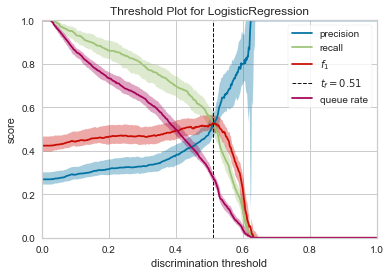

In [91]:
#logistic regression model
from sklearn.linear_model import LogisticRegression

log_rg = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                           verbose=0, warm_start=False)

churn_prediction(log_rg, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=True)

Algorithm: KNeighborsClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85      1589
           1       0.54      0.39      0.45       524

    accuracy                           0.77      2113
   macro avg       0.68      0.64      0.65      2113
weighted avg       0.75      0.77      0.75      2113

Accuracy Score: 0.7652626597255088
Area under curve: 0.6386362107811817 



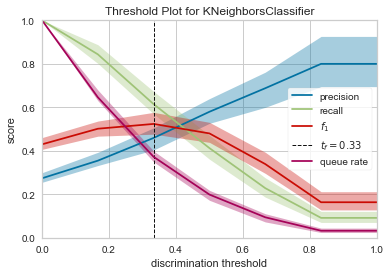

In [92]:
#K-NN 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
                           weights='uniform')

churn_prediction(knn, x_train, x_test, y_train, y_test, 'None', threshold_plot=True)

Algorithm: RandomForestClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      1589
           1       0.63      0.39      0.49       524

    accuracy                           0.79      2113
   macro avg       0.73      0.66      0.68      2113
weighted avg       0.78      0.79      0.78      2113

Accuracy Score: 0.7931850449597728
Area under curve: 0.6591199515754784 



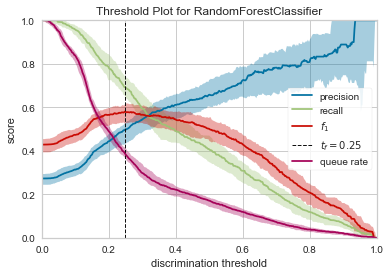

In [93]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state=1234, max_depth = 9, criterion = "gini")

churn_prediction(rf, x_train, x_test, y_train, y_test, 'features', threshold_plot=True)

Algorithm: GaussianNB

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.84      1589
           1       0.49      0.39      0.44       524

    accuracy                           0.75      2113
   macro avg       0.65      0.63      0.64      2113
weighted avg       0.73      0.75      0.74      2113

Accuracy Score: 0.7477520113582584
Area under curve: 0.628912273790708 



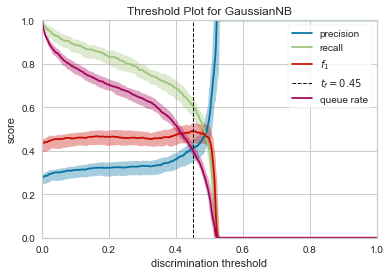

In [94]:
from sklearn.naive_bayes import GaussianNB

gsnb = GaussianNB(priors=None)
churn_prediction(gsnb, x_train, x_test, y_train, y_test, 'None', threshold_plot=True)